In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [3]:
sales = pd.read_excel('./Relatas_ML_Assignment/sales-pipeline.xlsx')
sales_conf = pd.read_excel('./Relatas_ML_Assignment/sales-pipeline.xlsx')

In [4]:
sentiment = pd.read_excel('sentiment.xlsx')
sentiment_conf = pd.read_excel('sentiment.xlsx')

In [5]:
sentiment['InteractionDate'] = pd.to_datetime(sentiment['InteractionDate'])
sentiment_conf['InteractionDate'] = pd.to_datetime(sentiment_conf['InteractionDate'])

grouped = sentiment.set_index(['InteractionDate'])
goruped_conf = sentiment_conf.set_index(['InteractionDate'])

grouped.loc[grouped.sentiment == 'POSITIVE', 'positive'] = 1
grouped['positive'] = grouped['positive'].fillna(0)
grouped.loc[grouped.sentiment == 'NEGATIVE', 'negative'] = 1
grouped['negative'] = grouped['negative'].fillna(0)

goruped_conf.loc[(goruped_conf.sentiment == 'POSITIVE') &  (goruped_conf.conf>=0.95) , 'positive'] = 1
goruped_conf.loc[(goruped_conf.sentiment == 'NEGATIVE') &  (goruped_conf.conf>=0.95) , 'negative'] = 1
goruped_conf['positive'] = goruped_conf['positive'].fillna(0)
goruped_conf['negative'] = goruped_conf['negative'].fillna(0)

In [6]:
for index,rows in sales.iterrows():
    a = rows['ContactEmailID']
    sales.loc[index,'postive']  = grouped.loc[rows['Created Date']:rows['Close Date']].query('positive == 1 and toEmailId==@a')['positive'].sum()
    sales.loc[index,'negative']  = grouped.loc[rows['Created Date']:rows['Close Date']].query('negative == 1 and toEmailId==@a')['negative'].sum()

In [7]:
for index,rows in sales_conf.iterrows():
    a = rows['ContactEmailID']
    sales_conf.loc[index,'postive']  = goruped_conf.loc[rows['Created Date']:rows['Close Date']].query('positive == 1 and toEmailId==@a')['positive'].sum()
    sales_conf.loc[index,'negative']  = goruped_conf.loc[rows['Created Date']:rows['Close Date']].query('negative == 1 and toEmailId==@a')['negative'].sum()
sales_conf['sum']  = sales_conf['postive'] + sales_conf['negative']
sales['sum'] = sales['postive'] + sales['negative']
sales_conf['diff']  = sales_conf['postive'] - sales_conf['negative']
sales['diff'] = sales['postive'] - sales['negative']
sales_conf.rename(columns={"Close Date":"Close_Date"} ,inplace=True)

In [8]:
week_won  = sales_conf.query('Deal_Stage == "Won"')
weekly = week_won.resample('W-Mon', on='Close_Date').sum().reset_index().sort_values(by='Close_Date')
data  = weekly.set_index('Close_Date')[['Close_Value','diff']]

In [9]:
data

,Close_Value,diff
Close_Date,,
2016-02-01,8703,2.0
2016-02-08,0,0.0
2016-02-15,1070,-4.0
2016-02-22,0,0.0
2016-02-29,0,0.0
...,...,...
2019-12-09,48464,479.0
2019-12-16,67665,774.0
2019-12-23,74491,864.0


In [10]:
#data = data.loc[:'2019-07-01']

In [11]:
train_data  = data.loc[:'20190701']
test_data = data.loc['20190701':]

In [12]:
len(test_data.index)

28

In [13]:
train_data_diff = train_data.diff().dropna()

<AxesSubplot:xlabel='Close_Date'>

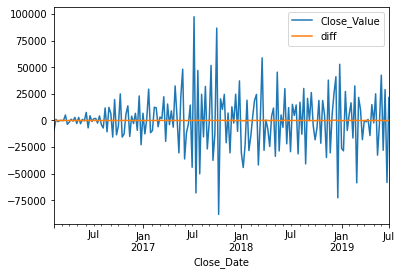

In [14]:
train_data_diff.plot()

In [15]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [16]:
for name, column in train_data_diff.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Close_Value" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.3655
 No. Lags Chosen       = 4
 Critical value 1%     = -3.469
 Critical value 5%     = -2.878
 Critical value 10%    = -2.576
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "diff" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.1147
 No. Lags Chosen       = 4
 Critical value 1%     = -3.469
 Critical value 5%     = -2.878
 Critical value 10%    = -2.576
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




In [17]:
#train_data_diff = train_data_diff.diff().dropna()

In [18]:
for name, column in train_data_diff.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Close_Value" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.3655
 No. Lags Chosen       = 4
 Critical value 1%     = -3.469
 Critical value 5%     = -2.878
 Critical value 10%    = -2.576
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "diff" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.1147
 No. Lags Chosen       = 4
 Critical value 1%     = -3.469
 Critical value 5%     = -2.878
 Critical value 10%    = -2.576
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




<AxesSubplot:xlabel='Close_Date'>

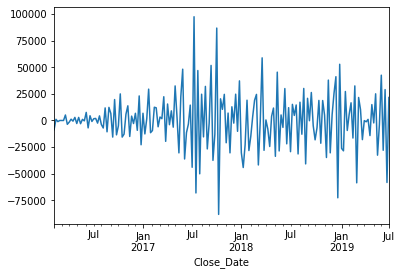

In [19]:
train_data_diff['Close_Value'].plot()

<AxesSubplot:xlabel='Close_Date'>

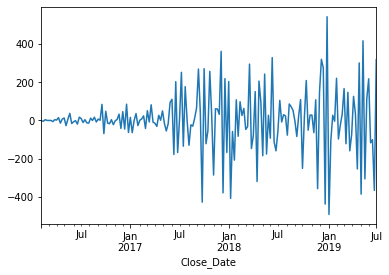

In [20]:
train_data_diff['diff'].plot()

In [21]:
model = VAR(train_data_diff)
x = model.select_order(maxlags=12)
x.summary()

/home/ai/.virtualenvs/face_deep/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)


,AIC,BIC,FPE,HQIC
0,30.32,30.36,1.470e+13,30.33
1,29.53,29.64,6.687e+12,29.58
2,29.46,29.65,6.235e+12,29.54
3,29.36,29.62*,5.634e+12,29.47
4,29.33,29.67,5.459e+12,29.47*
5,29.31*,29.73,5.378e+12*,29.48
6,29.35,29.84,5.580e+12,29.55
7,29.39,29.95,5.785e+12,29.61
8,29.38,30.02,5.758e+12,29.64
9,29.39,30.10,5.801e+12,29.68


In [22]:
fitted = model.fit(5)

In [23]:
def adjust(val, length= 28): return str(val).ljust(length)
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(fitted.resid)

for col, val in zip(data.columns, out):
    print(adjust(col), ':', round(val, 2))

Close_Value                  : 1.99
diff                         : 2.03


In [24]:
lag_order = fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = train_data_diff.values[-lag_order:]
forecast_input

5


array([[ 42550.,    218.],
       [-27991.,   -117.],
       [ 29010.,   -101.],
       [-58224.,   -366.],
       [ 21601.,    318.]])

In [25]:
fc = fitted.forecast(y=forecast_input, steps=28)
df_forecast = pd.DataFrame(fc, index=data.index[-28:], columns=data.columns + '_1d')
df_forecast

,Close_Value_1d,diff_1d
Close_Date,,
2019-07-01,-8018.044257,-52.578437
2019-07-08,10313.851231,114.156890
2019-07-15,1845.159583,-52.092450
2019-07-22,2857.970672,-22.449405
2019-07-29,-5318.311391,-33.795530
2019-08-05,-535.453390,32.926414
2019-08-12,-281.337563,10.323548
2019-08-19,1645.638476,20.203694
2019-08-26,1356.061213,-10.256865


In [26]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [27]:
df_results = invert_transformation(train_data, df_forecast, second_diff=False)        
df_results.loc[:, ['Close_Value_forecast', 'diff_forecast']]

,Close_Value_forecast,diff_forecast
Close_Date,,
2019-07-01,30214.955743,471.421563
2019-07-08,40528.806974,585.578453
2019-07-15,42373.966556,533.486002
2019-07-22,45231.937228,511.036597
2019-07-29,39913.625838,477.241068
2019-08-05,39378.172447,510.167481
2019-08-12,39096.834884,520.491030
2019-08-19,40742.473360,540.694724
2019-08-26,42098.534572,530.437859


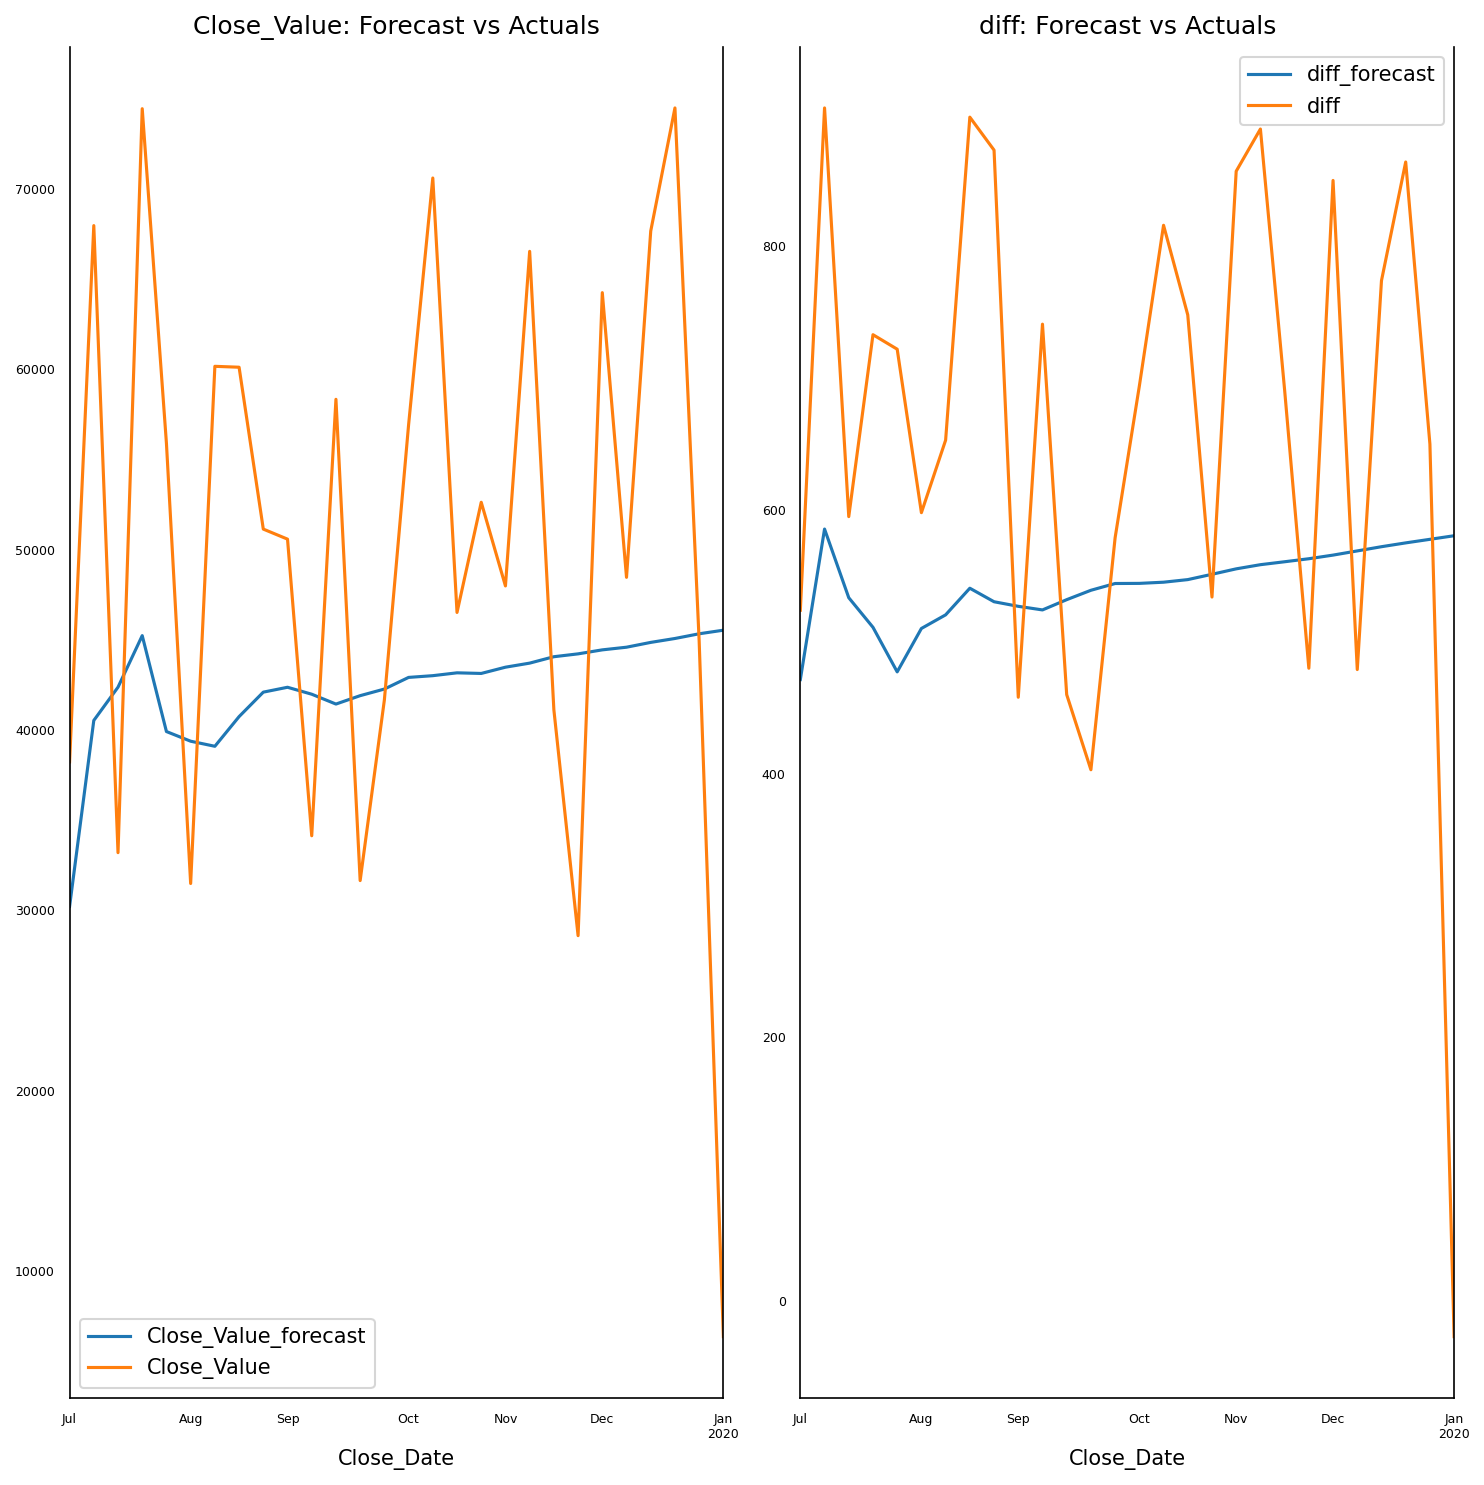

In [28]:
fig, axes = plt.subplots(nrows=int(len(data.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    test_data[col][-28:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [29]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: Close_Value')
accuracy_prod = forecast_accuracy(df_results['Close_Value_forecast'].values, test_data['Close_Value'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: diff')
accuracy_prod = forecast_accuracy(df_results['diff_forecast'].values, test_data['diff'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))


Forecast Accuracy of: Close_Value
mape                         :  0.4613
me                           :  -7821.3091
mae                          :  14529.7951
mpe                          :  0.1014
rmse                         :  17600.6449
corr                         :  0.1099
minmax                       :  0.2568

Forecast Accuracy of: diff
mape                         :  1.0356
me                           :  -115.2707
mae                          :  192.0516
mpe                          :  -0.9615
rmse                         :  232.4078
corr                         :  0.027
minmax                       :  0.2629


In [30]:
results = df_results.loc[:, ['Close_Value_forecast', 'diff_forecast']]

In [31]:
results = results.resample('M').sum()

MONTH JUNE

In [32]:
month = results.loc['2019-07-31']
month[0]

198263.29233880923

QUATERLY

In [33]:
q3 = results.loc['2019-07-01': '2019-9-30'].sum()
q4 = results.loc['2019-10-01': '2019-12-31'].sum()
q3[0],q4[0]

(569543.1341140816, 572004.7113147259)

HALF YEAR

In [34]:
half_year = results.loc['2019-07-01': '2019-12-31'].sum()
half_year[0]

1141547.8454288077